In [1]:
import random
import tensorflow as tf
from tensorflow import keras
import os
import PIL
import PIL.Image
import numpy as np
from tensorflow.keras.preprocessing.image import load_img
from pathlib import Path
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tqdm import tqdm
import pandas as pd
import json
from collections import defaultdict
import cv2
from imgaug import augmenters as iaa

<h3>Reference</h3>
   1. Bolg post-https://towardsdatascience.com/image-similarity-using-triplet-loss-3744c0f67973
   2. code reference:- https://keras.io/examples/vision/siamese_network/
   3. blog post(Triplet mining)-https://omoindrot.github.io/triplet-loss

# Data Loading

In [2]:
categories=['bags','belts','dresses','eyewear','footwear','hats','leggings','outerwear','pants','skirts','tops']
image_id=[]
product_id=[]
product_type=[]
inshop_df=pd.DataFrame()
for i in categories:
    with open('Dataset/street2shop/meta/json/retrieval_'+i+'.json') as f:
        temp=json.load(f)
        for j in temp:
            image_id.append(j['photo'])
            product_id.append(j['product'])
            product_type.append(i)
inshop_df['image_id']=image_id
inshop_df['product_id']=product_id
inshop_df['product_type']=product_type
print("no of inshope images are",len(set(inshop_df['image_id'])))
inshop_df.head()

no of inshope images are 404483


,image_id,product_id,product_type
0,75161,1,bags
1,75162,1,bags
2,249331,2,bags
3,206867,3,bags
4,371076,4,bags


In [3]:
image_id=[]
product_id=[]
product_type=[]
b_box=[]
street_df=pd.DataFrame()
for i in categories:
    for j in ['train','test']:
        with open('Dataset/street2shop/meta/meta/json/'+j+'_pairs_'+i+'.json') as f:
            temp=json.load(f)
            for k in temp:
                image_id.append(k['photo'])
                product_id.append(k['product'])
                product_type.append(i)
                b_box.append(k['bbox'])
street_df['image_id']=image_id
street_df['product_id']=product_id
street_df['product_type']=product_type
street_df['bbox']=b_box
street_df.head()

,image_id,product_id,product_type,bbox
0,2281,7871,bags,"{'width': 112, 'top': 335, 'height': 204, 'lef..."
1,15566,6788,bags,"{'width': 253, 'top': 1685, 'height': 322, 'le..."
2,9127,10805,bags,"{'width': 275, 'top': 154, 'height': 399, 'lef..."
3,4345,7464,bags,"{'width': 821, 'top': 1527, 'height': 949, 'le..."
4,9242,887,bags,"{'width': 171, 'top': 741, 'height': 184, 'lef..."


In [4]:
def get_product_type(image_name):
    image_name=image_name.split('\\')[-1]
    street_image_id=int(image_name.split("_")[0])
    product_id=int(image_name.split("_")[1])
    inshope_image_id=int(image_name.split("_")[2][:-4])
    product_type=list(set(street_df[(street_df['image_id']==street_image_id) &  (street_df['product_id']==product_id)].product_type.values))[0]
    return product_type

In [5]:
from collections import Counter
path=Path('Dataset/street2shop/Triplate/')
images_paths=os.listdir(path / 'Anchor/')
types=[]
for i in images_paths:
    types.append(get_product_type(i))
Counter(types)

Counter({'footwear': 9723,
         'dresses': 17389,
         'tops': 3965,
         'hats': 213,
         'skirts': 2214,
         'bags': 1631,
         'outerwear': 2217,
         'leggings': 1813,
         'belts': 270,
         'pants': 600,
         'eyewear': 416})

Here, below i have removed the images that belongs to the minor class such as hats,belts,eyewear.

In [6]:
path=Path('Dataset/street2shop/Triplate/')
images_paths=os.listdir(path / 'Anchor/')
anchor_images_paths=[]
positive_images_paths=[]
negative_images_paths=[]

types=['hats','belts','eyewear']
for i in images_paths:
    if get_product_type(i) not in types:
        anchor_images_paths.append(i)
        positive_images_paths.append(i)
        negative_images_paths.append(i)
anchor_images_paths = sorted([str(path / 'Anchor/' / f) for f in anchor_images_paths])
positive_images_paths=sorted([str(path / 'pos/' / f) for f in positive_images_paths])
negative_images_paths=sorted([str(path / 'neg/'/ f) for f in negative_images_paths])
target_shape=(256, 256)

In [7]:
len(anchor_images_paths),len(positive_images_paths),len(negative_images_paths)

(39552, 39552, 39552)

<h2>Creation of Train, Test and validation dataset

In [8]:
#train & test split(80:20)
idx=int(len(anchor_images_paths)*.8)
anchor_images_paths_test=anchor_images_paths[idx:]
positive_images_paths_test=positive_images_paths[idx:]
negative_images_paths_test=negative_images_paths[idx:]
anchor_images_paths=anchor_images_paths[:idx]
positive_images_paths=positive_images_paths[:idx]
negative_images_paths=negative_images_paths[:idx]

#train & validation split(80:20)
idx=int(len(anchor_images_paths)*.8)
anchor_images_paths_val=anchor_images_paths[idx:]
positive_images_paths_val=positive_images_paths[idx:]
negative_images_paths_val=negative_images_paths[idx:]
anchor_images_paths_train=anchor_images_paths[:idx]
positive_images_paths_train=positive_images_paths[:idx]
negative_images_paths_train=negative_images_paths[:idx]


In [9]:
def preprocess_image(path):
    """
    Load the specified file as a JPEG image, preprocess it and
    resize it to the target shape.
    """
    image_string = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, target_shape,method='area')
    return image
def preprocess_triplets(anchor, positive, negative,aug=True):
    """
    Given the id corresponding to the three images, load and
    preprocess them.
    """ 
    #https://imgaug.readthedocs.io/en/latest/source/examples_basics.html
    aug1 = iaa.flip.Fliplr(0.5)
    aug2 = iaa.Crop(percent=(0, 0.1))
    aug3 = iaa.GaussianBlur(sigma=(0, 3.0))
    aug4 = iaa.Dropout(p=0.01)
    aug5 = iaa.BlendAlpha((0.0, 1.0), ia.AllChannelsHistogramEqualization())
    anchor_img=preprocess_image(anchor)
    pos_img=preprocess_image(positive)
    neg_img=preprocess_image(negative)
    
    if aug:
            prob = np.random.uniform()
            if prob < 0.5 :
                i = np.random.uniform()
                if i < 0.2 :
                    anchor_img = aug1.augment_image(anchor_img)
                    pos_img = aug1.augment_image(pos_img)
                    neg_img = aug1.augment_image(neg_img)

                elif i < 0.4:
                    anchor_img = aug2.augment_image(anchor_img)
                    pos_img = aug2.augment_image(pos_img)
                    neg_img = aug2.augment_image(neg_img)

                elif i < 0.6:
                    anchor_img = aug3.augment_image(anchor_img)
                    pos_img = aug3.augment_image(pos_img)
                    neg_img = aug3.augment_image(neg_img)

                elif i < 0.8:
                    anchor_img = aug4.augment_image(anchor_img)
                    pos_img = aug4.augment_image(pos_img)
                    neg_img = aug4.augment_image(neg_img)
                
                elif i < 1 :
                    anchor_img = aug5.augment_image(anchor_img)
                    pos_img = aug5.augment_image(pos_img)
                    neg_img = aug5.augment_image(neg_img)
    anchor_img=tf.image.convert_image_dtype(anchor_img, tf.float32)
    pos_img=tf.image.convert_image_dtype(pos_img, tf.float32)
    neg_img=tf.image.convert_image_dtype(neg_img, tf.float32)
    return anchor_img,pos_img,neg_img 

In [10]:
def get_dataset(anchor_images_paths,positive_images_paths,negative_image_paths,batch_size=32,aug=True):
    anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_images_paths)
    positive_dataset = tf.data.Dataset.from_tensor_slices(positive_images_paths)
    negative_dataset =tf.data.Dataset.from_tensor_slices(negative_image_paths)
    dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
    dataset = dataset.shuffle(buffer_size=1024)
    dataset = dataset.map(lambda a,p,n: preprocess_triplets(a,p,n,aug))
    dataset = dataset.take(idx)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(8)
    return dataset
    

In [12]:
train_dataset=get_dataset(anchor_images_paths_train,positive_images_paths_train,negative_images_paths_train,aug=True)
val_dataset=get_dataset(anchor_images_paths_val,positive_images_paths_val,negative_images_paths_val,aug=False)
test_dataset=get_dataset(anchor_images_paths_test,positive_images_paths_test,negative_images_paths_test,aug=False)


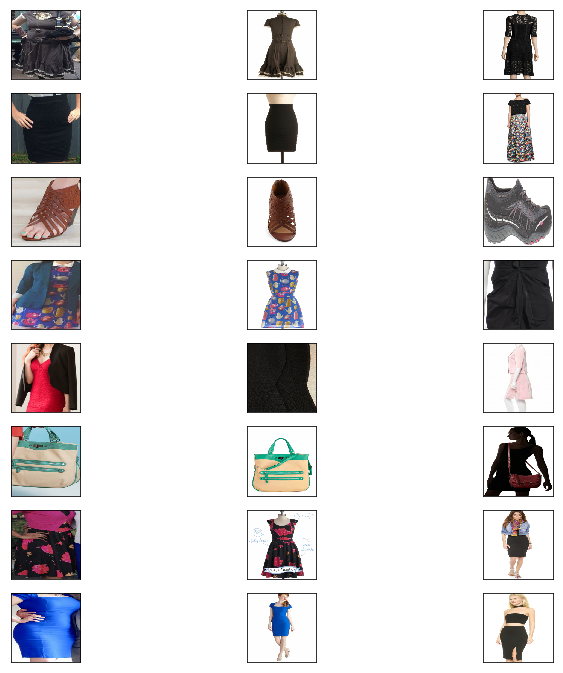

In [13]:
def visualize(anchor, positive, negative):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(12, 12))

    axs = fig.subplots(8,3)
    for i in range(8):
        #print(anchor[i])
        show(axs[i,0], anchor[i])
        show(axs[i,1], positive[i])
        show(axs[i,2], negative[i])


visualize(*list(train_dataset.take(4).as_numpy_iterator())[0])

In [14]:
len(anchor_images_paths_train),len(anchor_images_paths_val),len(anchor_images_paths_test)

(25312, 6329, 7911)

In [15]:
len(positive_images_paths_train),len(positive_images_paths_val),len(positive_images_paths_test)

(25312, 6329, 7911)

In [16]:
len(negative_images_paths_train),len(negative_images_paths_val),len(negative_images_paths_test)

(25312, 6329, 7911)

# Triplet model architecture

In [17]:
embedding_size=2048
margin=0.2
alpha=0.00005
lr=0.00005

In [53]:
embedding_size=2048
from tensorflow.keras.applications import resnet
base_cnn = resnet.ResNet50(weights="imagenet", input_shape=target_shape + (3,), include_top=False,pooling='avg')

bn1 = tf.keras.layers.BatchNormalization()(base_cnn.output)
drop1=tf.keras.layers.Dropout(.5)(bn1)
act1=tf.keras.layers.Activation('relu')(drop1)
dense1=tf.keras.layers.Dense(embedding_size*2)(act1)

bn2 = tf.keras.layers.BatchNormalization()(dense1)
drop2=tf.keras.layers.Dropout(.5)(bn2)
output = tf.keras.layers.Dense(embedding_size)(drop2)
embedding = tf.keras.Model(base_cnn.input, output, name="Embedding")

trainable = False
for layer in base_cnn.layers:
    if layer.name == "conv5_block1_add":
        trainable = True
    layer.trainable = trainable

In [54]:
class DistanceLayer(tf.keras.layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        reg=tf.reduce_sum(tf.square(anchor),-1)+tf.reduce_sum(tf.square(anchor),-1)+tf.reduce_sum(tf.square(anchor),-1)
        reg=reg/(3*embedding_size)
        return (ap_distance, an_distance,reg)
    
    
anchor_input =  tf.keras.layers.Input(name="anchor", shape=target_shape + (3,))
positive_input =  tf.keras.layers.Input(name="positive", shape=target_shape + (3,))
negative_input =  tf.keras.layers.Input(name="negative", shape=target_shape + (3,))

distances = DistanceLayer()(embedding(resnet.preprocess_input(anchor_input)),embedding(resnet.preprocess_input(positive_input)),embedding(resnet.preprocess_input(negative_input)))

model= tf.keras.Model(inputs=[anchor_input, positive_input, negative_input], outputs=distances)

In [56]:
class Triplate(tf.keras.Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, network, margin=0.5,alpha=0):
        super(Triplate, self).__init__()
        self.network = network
        self.margin = margin
        self.alpha=alpha
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
    def call(self, inputs):
        return self.network(inputs)
    def train_step(self, data):
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)
        gradients = tape.gradient(loss, self.network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.network.trainable_weights))
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        ap_distance, an_distance,reg = self.network(data)
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)+self.alpha*reg
        return loss
    @property
    def metrics(self):
        return [self.loss_tracker]

<h3>UTILITY functions for Semi-hard triplate mining

In [57]:
def path_to_embs(img_path):
    img = image.load_img(img_path, target_size=(256, 256))
    x = image.img_to_array(img)
    x=np.expand_dims(x, axis=0)
    out=embedding(resnet.preprocess_input(x))
    return out

In [58]:
def get_hard_pos(a,p,n):
    a_emb=path_to_embs(a)
    p_emb=path_to_embs(p)
    n_emb=path_to_embs(n)
    ap_distance = tf.reduce_sum(tf.square(a_emb - p_emb), -1)
    an_distance = tf.reduce_sum(tf.square(a_emb - n_emb), -1)
    if ap_distance+margin>an_distance:
        return True
    else:
        return False
def get_semi_hard(anchor_images_paths,positive_images_paths,negative_image_paths):
    hard_anchor=[]
    hard_pos=[]
    hard_neg=[]
    for x in tqdm(range(len(anchor_images_paths))):
        if get_hard_pos(anchor_images_paths[x],positive_images_paths[x],negative_image_paths[x]):
            hard_anchor.append(anchor_images_paths[x])
            hard_pos.append(positive_images_paths[x])
            hard_neg.append(negative_image_paths[x])
    return hard_anchor,hard_pos,hard_neg

# Training

<h3>Methord-1:- Training on the whole dataset without triplet mining

In [59]:
#checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = 'Models/triplet_weight.hd5', monitor = 'val_loss', save_weights_only = True, save_best_only = True)
checkpoint_path = "./Models/Triplate_final_weights/cp0-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, verbose=1, save_weights_only=True,save_freq='epoch')

In [72]:
tf.keras.backend.clear_session()
triplate_model = Triplate(model,margin=0.2,alpha=0.00005)
triplate_model.compile(optimizer=tf.keras.optimizers.Adam(0.00005))
triplate_model.fit(train_dataset, epochs=5, validation_data=val_dataset,callbacks = [checkpoint])

Epoch 1/5
791/791 [==============================] - 1119s 1s/step - loss: 0.1382 - val_loss: 0.0872

Epoch 00001: saving model to ./Models/Triplate_final_weights\cp0-0001.ckpt
Epoch 2/5
791/791 [==============================] - 1141s 1s/step - loss: 0.1082 - val_loss: 0.0834

Epoch 00002: saving model to ./Models/Triplate_final_weights\cp0-0002.ckpt
Epoch 3/5
791/791 [==============================] - 1191s 2s/step - loss: 0.1002 - val_loss: 0.0954

Epoch 00003: saving model to ./Models/Triplate_final_weights\cp0-0003.ckpt
Epoch 4/5
791/791 [==============================] - 1172s 1s/step - loss: 0.0946 - val_loss: 0.0973

Epoch 00004: saving model to ./Models/Triplate_final_weights\cp0-0004.ckpt
Epoch 5/5
791/791 [==============================] - 1345s 2s/step - loss: 0.0876 - val_loss: 0.0957

Epoch 00005: saving model to ./Models/Triplate_final_weights\cp0-0005.ckpt


<h3>Methord-2:- Traing using semi hard triplet after each epoch

Here, in this methord first I trained 1st epoch on whole dataset,then on each epoch I am finding the hard and semi-hard triplates using the previous Epoch weights and train on those triplets.

<h4>Epoch 1

In [106]:
checkpoint_path = "./Models/Triplate_final_weights/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, verbose=1, save_weights_only=True,save_freq='epoch')

In [107]:
%%time
tf.keras.backend.clear_session()
triplate_model = Triplate(model,margin=0.2,alpha=0.00005)
triplate_model.compile(optimizer=tf.keras.optimizers.Adam(0.00005))
triplate_model.fit(train_dataset, epochs=1, validation_data=val_dataset,callbacks = [checkpoint])

791/791 [==============================] - 1183s 1s/step - loss: 0.1382 - val_loss: 0.0834

Epoch 00001: saving model to ./Models/Triplate_final_weights\cp-0001.ckpt
Wall time: 19min 45s


<h4>Epoch 2

In [111]:
hard_anchor_train, hard_pos_train, hard_neg_train = get_semi_hard(anchor_images_paths_train, positive_images_paths_train, negative_images_paths_train)
hard_anchor_val, hard_pos_val, hard_neg_val = get_semi_hard(anchor_images_paths_val, positive_images_paths_val, negative_images_paths_val)

100%|██████████████████████████████████████████████████████████████████████████████| 6329/6329 [26:27<00:00,  3.99it/s]


In [115]:
train_dataset_hard=get_dataset(hard_anchor_train, hard_pos_train, hard_neg_train)
val_dataset_hard=get_dataset(hard_anchor_val, hard_pos_val, hard_neg_val)
checkpoint_path = "./Models/Triplate_final_weights/cp2-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, verbose=1, save_weights_only=True,save_freq='epoch')
triplate_model.fit(train_dataset_hard, epochs=1, validation_data=val_dataset_hard,callbacks = [checkpoint])

263/263 [==============================] - 392s 1s/step - loss: 0.0763 - val_loss: 0.0702

Epoch 00001: saving model to ./Models/Triplate_final_weights\cp2-0001.ckpt


<h4>Epoch 3

In [117]:
hard_anchor_train, hard_pos_train, hard_neg_train = get_semi_hard(anchor_images_paths_train, positive_images_paths_train, negative_images_paths_train)
hard_anchor_val, hard_pos_val, hard_neg_val = get_semi_hard(anchor_images_paths_val, positive_images_paths_val, negative_images_paths_val)

100%|██████████████████████████████████████████████████████████████████████████████| 6329/6329 [25:52<00:00,  4.08it/s]


In [120]:
train_dataset_hard=get_dataset(hard_anchor_train, hard_pos_train, hard_neg_train)
val_dataset_hard=get_dataset(hard_anchor_val, hard_pos_val, hard_neg_val)
checkpoint_path = "./Models/Triplate_final_weights/cp3-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, verbose=1, save_weights_only=True,save_freq='epoch')
triplate_model.fit(train_dataset_hard, epochs=1, validation_data=val_dataset_hard,callbacks = [checkpoint])

274/274 [==============================] - 400s 1s/step - loss: 0.0601 - val_loss: 0.0778

Epoch 00001: saving model to ./Models/Triplate_final_weights\cp3-0001.ckpt


<h4>Epoch 4

In [121]:
hard_anchor_train, hard_pos_train, hard_neg_train = get_semi_hard(anchor_images_paths_train, positive_images_paths_train, negative_images_paths_train)
hard_anchor_val, hard_pos_val, hard_neg_val = get_semi_hard(anchor_images_paths_val, positive_images_paths_val, negative_images_paths_val)

100%|██████████████████████████████████████████████████████████████████████████████| 6329/6329 [25:36<00:00,  4.12it/s]


In [131]:
train_dataset_hard=get_dataset(hard_anchor_train, hard_pos_train, hard_neg_train)
val_dataset_hard=get_dataset(hard_anchor_val, hard_pos_val, hard_neg_val)
checkpoint_path = "./Models/Triplate_final_weights/cp4-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, verbose=1, save_weights_only=True,save_freq='epoch')
triplate_model.fit(train_dataset_hard, epochs=1, validation_data=val_dataset_hard,callbacks = [checkpoint])

275/275 [==============================] - 414s 2s/step - loss: 0.0565 - val_loss: 0.0597

Epoch 00001: saving model to ./Models/Triplate_final_weights\cp4-0001.ckpt


<h4>Epoch 5

In [184]:
hard_anchor_train, hard_pos_train, hard_neg_train = get_semi_hard(anchor_images_paths_train, positive_images_paths_train, negative_images_paths_train)
hard_anchor_val, hard_pos_val, hard_neg_val = get_semi_hard(anchor_images_paths_val, positive_images_paths_val, negative_images_paths_val)

100%|██████████████████████████████████████████████████████████████████████████████| 6329/6329 [23:37<00:00,  4.47it/s]


In [192]:
train_dataset_hard=get_dataset(hard_anchor_train, hard_pos_train, hard_neg_train)
val_dataset_hard=get_dataset(hard_anchor_val, hard_pos_val, hard_neg_val)
checkpoint_path = "./Models/Triplate_final_weights/cp5-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, verbose=1, save_weights_only=True,save_freq='epoch')
triplate_model.fit(train_dataset_hard, epochs=1, validation_data=val_dataset_hard,callbacks = [checkpoint])

280/280 [==============================] - 346s 1s/step - loss: 0.0483 - val_loss: 0.0605

Epoch 00001: saving model to ./Models/Triplate_final_weights\cp5-0001.ckpt


<h4>Epoch 6

In [208]:
hard_anchor_train, hard_pos_train, hard_neg_train = get_semi_hard(anchor_images_paths_train, positive_images_paths_train, negative_images_paths_train)
hard_anchor_val, hard_pos_val, hard_neg_val = get_semi_hard(anchor_images_paths_val, positive_images_paths_val, negative_images_paths_val)

100%|██████████████████████████████████████████████████████████████████████████████| 6329/6329 [25:51<00:00,  4.08it/s]


In [221]:
train_dataset_hard=get_dataset(hard_anchor_train, hard_pos_train, hard_neg_train)
val_dataset_hard=get_dataset(hard_anchor_val, hard_pos_val, hard_neg_val)
checkpoint_path = "./Models/Triplate_final_weights/cp6-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, verbose=1, save_weights_only=True,save_freq='epoch')
triplate_model.fit(train_dataset_hard, epochs=1, validation_data=val_dataset_hard,callbacks = [checkpoint])

282/282 [==============================] - 386s 1s/step - loss: 0.0439 - val_loss: 0.0591

Epoch 00001: saving model to ./Models/Triplate_final_weights\cp6-0001.ckpt


<h4>Epoch 7

In [239]:
hard_anchor_train, hard_pos_train, hard_neg_train = get_semi_hard(anchor_images_paths_train, positive_images_paths_train, negative_images_paths_train)
hard_anchor_val, hard_pos_val, hard_neg_val = get_semi_hard(anchor_images_paths_val, positive_images_paths_val, negative_images_paths_val)

100%|██████████████████████████████████████████████████████████████████████████████| 6329/6329 [25:55<00:00,  4.07it/s]


In [249]:
train_dataset_hard=get_dataset(hard_anchor_train, hard_pos_train, hard_neg_train)
val_dataset_hard=get_dataset(hard_anchor_val, hard_pos_val, hard_neg_val)
checkpoint_path = "./Models/Triplate_final_weights/cp7-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, verbose=1, save_weights_only=True,save_freq='epoch')
triplate_model.fit(train_dataset_hard, epochs=1, validation_data=val_dataset_hard,callbacks = [checkpoint])

283/283 [==============================] - 472s 2s/step - loss: 0.0419 - val_loss: 0.0624

Epoch 00001: saving model to ./Models/Triplate_final_weights\cp7-0001.ckpt


# Creating embedding vectors

In [73]:
def store_emb():
    image_name=os.listdir('Dataset/street2shop/Triplate/pos')
    image_names=[]
    keys=[]
    for i in (image_name):# filter inng uniue_images
        key=i.split('.')[0].split("_")[1]+"_"+i.split('.')[0].split("_")[2]
        if key not in keys:
            image_names.append(i)
            keys.append(key)
    cat_to_emb={'bags':{},'belts':{},'dresses':{},'eyewear':{},'footwear':{},'hats':{},'leggings':{},'outerwear':{},'pants':{},'skirts':{},'tops':{}}
    for i in tqdm(image_names):
        cat=get_product_type(i)
        path='Dataset/street2shop/Triplate/pos/'+i
        cat_to_emb[cat][path]=path_to_embs(path)
    return cat_to_emb

In [74]:
triplate_model.load_weights("./Models/Triplate_final_weights/cp6-0001.ckpt")
cat_to_emb=store_emb()
# Save
np.save('Models/emb.npy', cat_to_emb)

100%|████████████████████████████████████████████████████████████████████████████| 24332/24332 [30:37<00:00, 13.24it/s]


In [ ]:
 # Load
cat_to_emb = np.load('Models/emb.npy',allow_pickle='TRUE').item()

# Inferance

In [91]:
def get_simalar_image(image_vetor,image_type):
    path_to_emb=cat_to_emb[image_type]
    embs= tf.convert_to_tensor(list(path_to_emb.values()), dtype=tf.float32)
    num=tf.matmul(embs,image_vetor,transpose_b=True)
    p=tf.linalg.normalize(embs,axis=-1)[1]
    q=tf.linalg.normalize(image_vetor,axis=-1)[1]
    den=tf.matmul(p,q,transpose_b=True)
    similarity_values=tf.math.divide(num, den)
    similarity_values=tf.squeeze(similarity_values, axis=-1)
    idx=np.argpartition(similarity_values,axis=0,kth=-6)[-6:]
    simalar_path=[]
    for i in idx[-6:]:
        simalar_path.append(list(path_to_emb.keys())[i[0]])
    return simalar_path

In [92]:
def get_true_image(path):
    df=path.split('\\')[-1]
    product_type=get_product_type(df)
    street_image_id=int(df.split("_")[0])
    product_id=int(df.split("_")[1])
    df=inshop_df[(inshop_df['product_id']==product_id) & (inshop_df['product_type']==product_type)].image_id
    paths=sorted(os.listdir('Dataset\\street2shop\\Triplate\\pos\\'))
    df=set([str(street_image_id)+"_"+str(product_id)+"_"+str(i)+".jpg" for i in df])
    df=list(set(paths).intersection(df))
    df=['Dataset/street2shop/Triplate/pos/'+i for i in df]
    return df


In [122]:
def draw_images_from_path(paths,title):
    fig = plt.figure(figsize=(12, 12))
    #fig.suptitle(title)
    ax = fig.subplots(1,len(paths))
    for i in range(len(paths)):
        img=image.load_img(paths[i], target_size=(220, 220))
        ax[i].set_title(title+" "+str(i))
        ax[i].imshow(img)
    

C:\Users\suraj\Anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
C:\Users\suraj\Anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
C:\Users\suraj\Anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume t

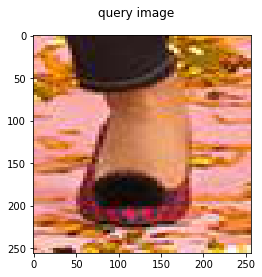

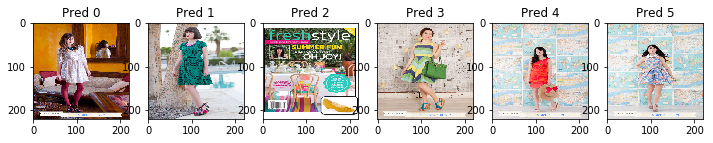

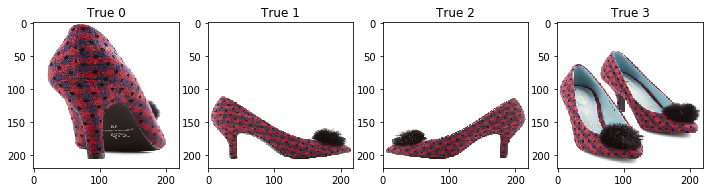

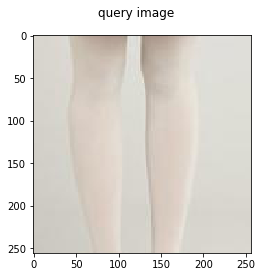

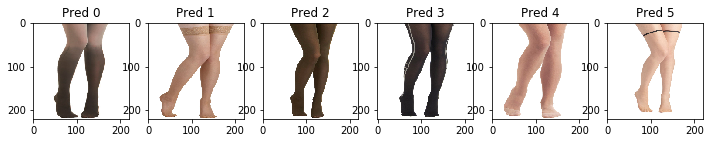

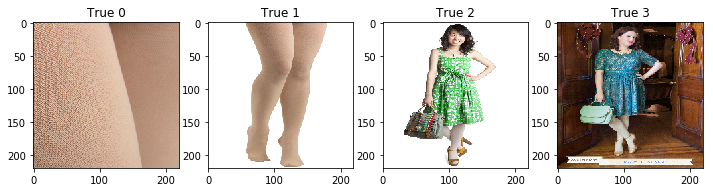

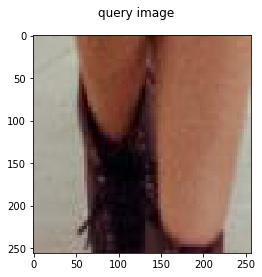

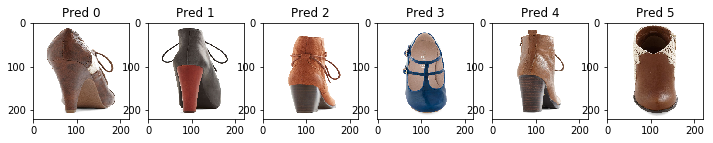

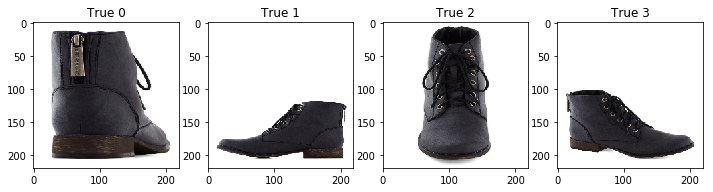

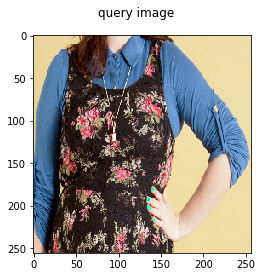

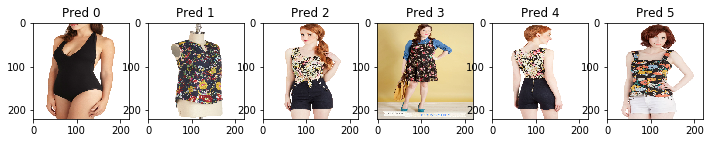

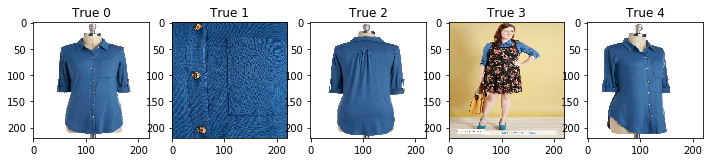

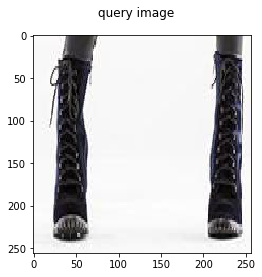

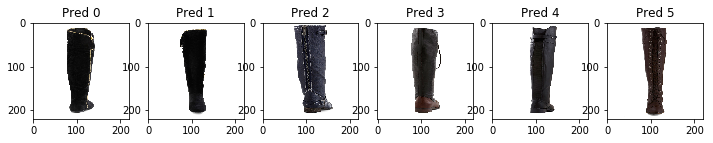

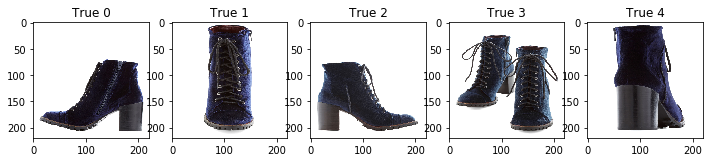

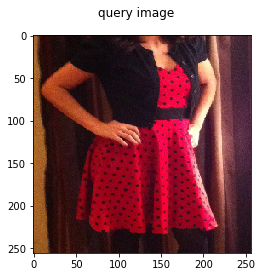

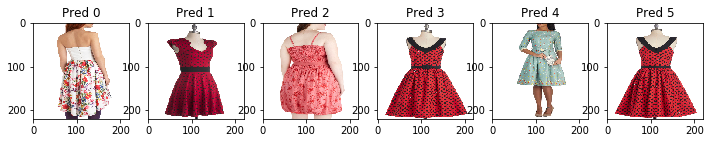

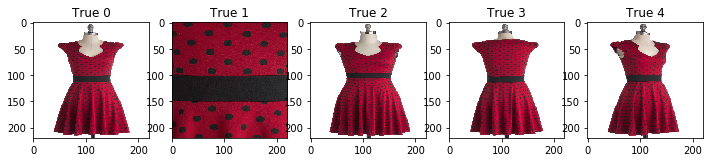

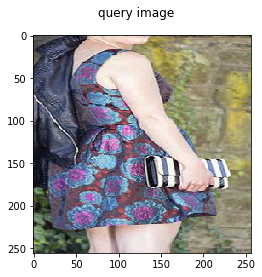

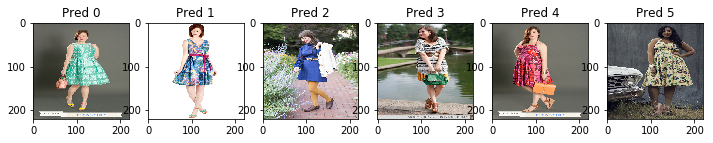

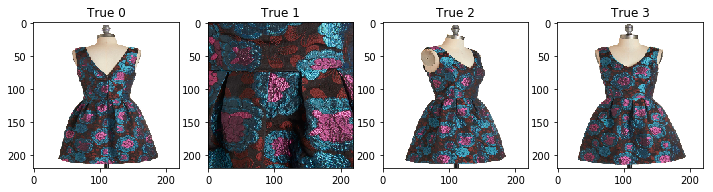

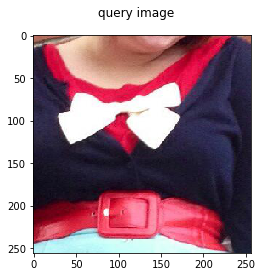

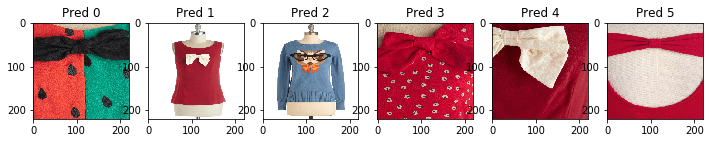

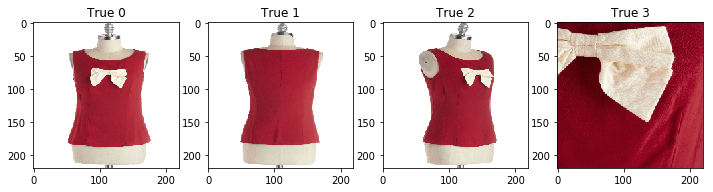

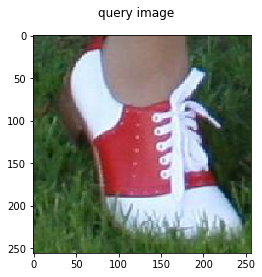

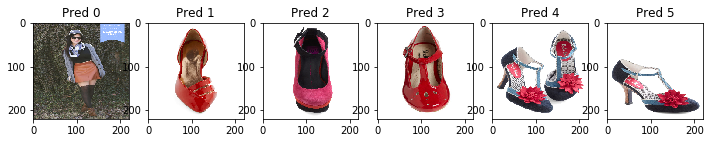

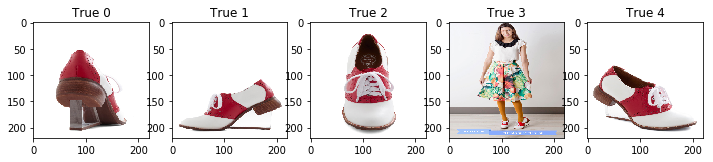

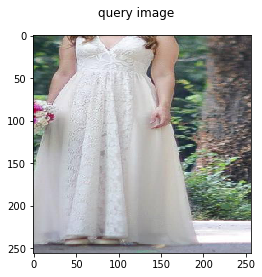

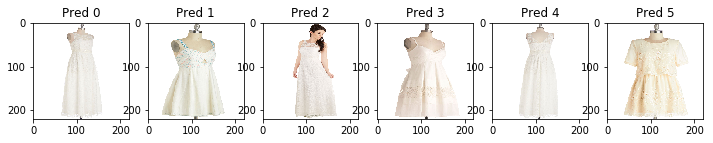

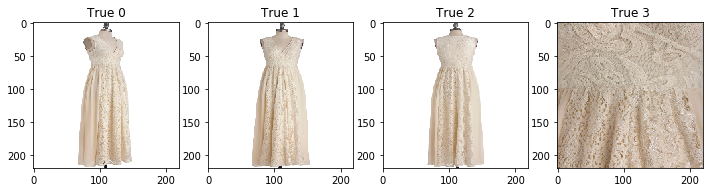

In [127]:
for i in range(10):
    idx=random.randint(0,len(anchor_images_paths_test))
    Ouery_path=anchor_images_paths_test[idx]
    Query_img_type=get_product_type(Ouery_path)
    Query_emb=path_to_embs(Ouery_path)
    pred_img=get_simalar_image(Query_emb,Query_img_type)
    actuall_img=get_true_image(Ouery_path)
    fig = plt.figure()
    fig.suptitle('query image')
    img=image.load_img(Ouery_path, target_size=(256, 256))
    plt.imshow(img)
    draw_images_from_path(pred_img,'Pred')
    draw_images_from_path(list(actuall_img,'True')

In [86]:
val_img=anchor_images_paths_test
acc=0
for i in tqdm(val_img):
    Query_img_type=get_product_type(i)
    Query_emb=path_to_embs(i)
    pred_img=set(get_simalar_image(Query_emb,Query_img_type))
    true_img=set(get_true_image(i))
    if len(pred_img.intersection(true_img))>=1:
        acc=acc+1
print("accuracy is ",(acc/len(val_img)))

100%|██████████████████████████████████████████████████████████████████████████████| 7911/7911 [20:25<00:00,  6.46it/s]

accuracy is  0.28619643534319306


<h2>Summary:-

   1.   Training without semi-hard triplet mining does't converge easily and after few epoch starts overfitting because we can onserve that after first epoch there only 33% of the triplets having positive loss.So traaining on the whole dataset is not converge easily.<br>
   
   2.  After using the semi-hard triplet mining methord the loss converges faster.<br>
   
   3.  The accuracy without using the triplet mining is arround 7% and after using the semi-hard triplet mining the accuracy goes to 28% and we can observe that sometimes the prediction images looks much accurate than the original shop image.